# Mask R-CNN Inference Example
This notebook demonstrates how to use a pretrained Mask R-CNN model for object detection and instance segmentation.

Main steps:
1. Import necessary libraries.
2. Define model and helper functions.
3. Load pretrained weights.
4. Read and preprocess the test image.
5. Perform inference and visualize results.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/mask_rcnn')
!pwd
!ls

/content/drive/.shortcut-targets-by-id/1X6NgfCWvLtS1EkioZUmeOsWW1V9yptnR/mask_rcnn
1.jpg				my_dataset_voc.py	 requirements.txt
backbone			network_files		 result
coco91_indices.json		pascal_voc_indices.json  save_weights
det_results20220406-141544.txt	plot_curve.py		 seg_results20220406-141544.txt
draw_box_utils.py		predict2.py		 test_result.jpg
images				predict3.py		 train_multi_GPU.py
main.ipynb			predict4.py		 train.py
main_predict_E.ipynb		predict.py		 train_utils
main_predict.ipynb		__pycache__		 transforms.py
multi_train			qw			 validation.py
my_dataset_coco.py		README.md


In [3]:
pip install "pillow<10.0"

In [4]:
import os
import time
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Make sure the following modules/files are accessible in your environment:
# 1. network_files (should include MaskRCNN, etc.)
# 2. backbone (should include resnet50_fpn_backbone, etc.)
# 3. draw_box_utils (should include draw_objs, etc.)
from network_files import MaskRCNN
from backbone import resnet50_fpn_backbone
from draw_box_utils import draw_objs

## Define Model and Helper Functions
Including:
1. `create_model`: Create the Mask R-CNN model.
2. `time_synchronized`: Helper for GPU-synchronized time measurement.

In [5]:
def create_model(num_classes, box_thresh=0.5):
    """
    Create a Mask R-CNN model.
    Args:
        num_classes: number of classes (including background)
        box_thresh: score threshold for RPN and ROI heads
    """
    # Use ResNet50 FPN as the backbone
    backbone = resnet50_fpn_backbone()

    # Instantiate MaskRCNN with the given backbone and thresholds
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_score_thresh=box_thresh,  # RPN score threshold
        box_score_thresh=box_thresh   # ROI score threshold
    )

    return model


def time_synchronized():
    """
    Return current time (synchronizes GPU if available).
    """
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    return time.time()

## Main Function
1. Set parameters: number of classes, confidence threshold, weights path, test image path, label JSON path.
2. Create and load model weights.
3. Read and preprocess the test image.
4. Perform inference to get bounding boxes, labels, scores, and instance masks.
5. Visualize and save the results.

In [6]:
def main():
    # Number of classes (for COCO dataset, it's typically 80, but coco91_indices.json might have 90 labels)
    # Adjust accordingly based on the actual labels file
    num_classes = 90  # 90 if not counting background; be sure to confirm
    box_thresh = 0.5  # Score threshold for RPN and ROI

    # Path to the model weights
    weights_path = "./save_weights/mask_rcnn_weights.pth"
    # Path to the test image
    img_path = "./qw/6.jpg"
    # Path to the JSON file containing label mappings
    label_json_path = './coco91_indices.json'

    # Select device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device: {}".format(device))

    # Create the model
    # Note: num_classes should include the background class, so we do num_classes + 1
    model = create_model(num_classes=num_classes + 1, box_thresh=box_thresh)

    # Load weights
    assert os.path.exists(weights_path), "{} file does not exist.".format(weights_path)
    weights_dict = torch.load(weights_path, map_location='cpu')
    # If the weights file has a 'model' key, extract it
    weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
    model.load_state_dict(weights_dict)
    model.to(device)

    # Load category index
    assert os.path.exists(label_json_path), "JSON file {} does not exist.".format(label_json_path)
    with open(label_json_path, 'r') as json_file:
        category_index = json.load(json_file)

    # Load test image
    assert os.path.exists(img_path), f"{img_path} does not exist."
    original_img = Image.open(img_path).convert('RGB')

    # Preprocessing: PIL -> Tensor (no normalization)
    data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img = data_transform(original_img)
    # Expand batch dimension [C, H, W] -> [1, C, H, W]
    img = torch.unsqueeze(img, dim=0)

    # Inference mode
    model.eval()
    with torch.no_grad():
        # Warm-up pass
        img_height, img_width = img.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        # Actual inference
        t_start = time_synchronized()
        predictions = model(img.to(device))[0]
        t_end = time_synchronized()
        print("Inference+NMS time: {:.4f} seconds".format(t_end - t_start))

        # Convert results to CPU
        predict_boxes = predictions["boxes"].to("cpu").numpy()
        predict_classes = predictions["labels"].to("cpu").numpy()
        predict_scores = predictions["scores"].to("cpu").numpy()
        predict_mask = predictions["masks"].to("cpu").numpy()
        # Squeeze from [batch, 1, h, w] to [batch, h, w]
        predict_mask = np.squeeze(predict_mask, axis=1)

        # If no objects are detected
        if len(predict_boxes) == 0:
            print("No objects detected!")
            return

        # Visualize detection results on the image
        plot_img = draw_objs(
            original_img,
            boxes=predict_boxes,
            classes=predict_classes,
            scores=predict_scores,
            masks=predict_mask,
            category_index=category_index,
            line_thickness=3,
            font='arial.ttf',
            font_size=20
        )

        # Show the results
        plt.imshow(plot_img)
        plt.show()

        # Save the result
        output_path = "./qw/6_result.jpg"
        plot_img.save(output_path)
        print(f"Prediction result has been saved to {output_path}")

## Run Main Function

Using device: cuda:0


<ipython-input-6-231489c3d3a3>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights_path, map_location='cpu')


Inference+NMS time: 0.1513 seconds


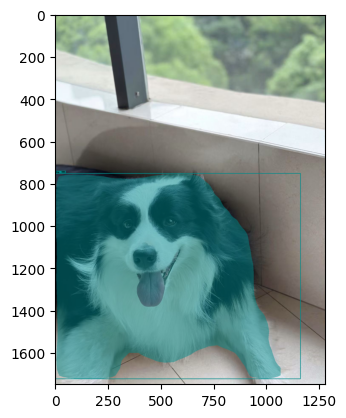

Prediction result has been saved to ./qw/6_result.jpg


In [9]:
if __name__ == '__main__':
    main()